<a href="https://colab.research.google.com/github/michaelgodoyf/tareas-proc-digi-multimedia/blob/main/Proyecto_1_Michael_godoy_F_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Michael Godoy Ferreira</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [116]:
!git clone https://github.com/Jorgecardenas1/EIE_401_MULTIMEDIA.git

fatal: destination path 'EIE_401_MULTIMEDIA' already exists and is not an empty directory.


In [117]:
!git clone https://github.com/michaelgodoyf/tareas-proc-digi-multimedia

fatal: destination path 'tareas-proc-digi-multimedia' already exists and is not an empty directory.


In [10]:
!pip install sounddevice
!pip install pydub
!pip install ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00


In [118]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

# Cambiando el nombre del archivo y las variables
archivo = "/content/tareas-proc-digi-multimedia/H-H1_GWOSC_16KHZ_R1-1265926087-32.txt"

# Cargando la señal desde el archivo
senal = np.loadtxt(archivo, delimiter=",", skiprows=1, dtype=float)
senal  # Mostrando la señal cargada


array([-9.44276822e-20, -8.89327781e-20, -9.76100401e-20, ...,
        8.29571764e-20,  6.86534663e-20,  7.56683614e-20])

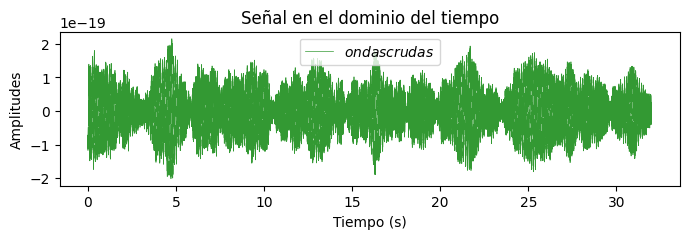

In [119]:
import numpy as np  # Importa NumPy y se le da el alias np
import matplotlib.pyplot as plt  # Importa Matplotlib y se le da el alias plt

# Frecuencia de muestreo
fs = 16000

# Vector de tiempo
tiempo = np.arange(senal.size)

# Tiempo máximo en segundos
tiempo_maximo = senal.size / fs

# Tiempos de inicio y fin deseados en segundos
tiempo_inicial = 0
tiempo_final = 32

# Muestras correspondientes a los tiempos de inicio y fin
muestra_inicial = tiempo_inicial * fs
muestra_final = tiempo_final * fs

# Pasos de tiempo para el intervalo deseado
pasos_tiempo = np.linspace(tiempo_inicial, tiempo_final, senal[muestra_inicial:muestra_final].size)

# Creación de la figura con un tamaño específico
plt.figure(figsize=(8, 2))

# Graficar la señal en el intervalo de tiempo deseado
plt.plot(pasos_tiempo, senal[muestra_inicial:muestra_final], "green", label=r"$ondas crudas$", alpha=0.8, linewidth=0.5)

# Configuraciones adicionales del gráfico
plt.title("Señal en el dominio del tiempo")
plt.legend(loc="upper center")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitudes")

# Mostrar la gráfica
plt.show()



## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [123]:
from scipy.io.wavfile import write
import IPython.display as ipd
from pydub import AudioSegment
fs=16000
muestra = senal[muestra_inicial:muestra_final]
#  valor máximo absoluto de la muestra
maximo= np.max(np.abs(muestra))

# señal a tipo de datos float32
df32 = (muestra/maximo).astype(np.float32)

# Escribe los datos de la muestra en un archivo WAV
write("raw_completo.wav", fs, df32)

# Reproduce el archivo WAV completo
ipd.Audio("raw_completo.wav")


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


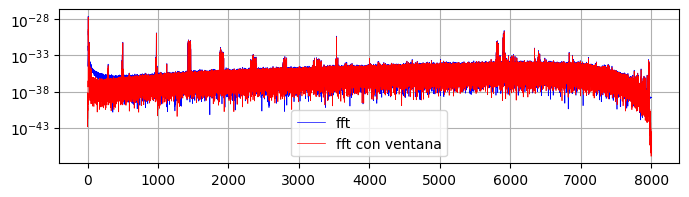

In [124]:
from scipy.fft import fft, fftfreq
from scipy.signal.windows import tukey

#  Transformada de Fourier
transformada_fourier = np.fft.fft(senal)

#  ventana de Tukey
N = muestra.size
T = 1.0 / fs
tiempo = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(muestra)
ventana = tukey(N, alpha=1./4)

#  Aplica la ventana y la Transformada de Fourier
ft_con_ventana = fft(muestra * ventana)

#  Crea los ejes de frecuencia
frecuencias = fftfreq(N, T)

# Calcula la densidad espectral de potencia
densidad_espectral = np.abs(yf[1:N//2])**2  # sin ventana
densidad_espectral_con_ventana = np.abs(ft_con_ventana[1:N//2])**2  # con ventana

#  Visualiza los resultados en una escala logarítmica
plt.figure(figsize=(8, 2))
plt.semilogy(frecuencias[1:N//2], densidad_espectral, "-b", linewidth=0.5)
plt.semilogy(frecuencias[1:N//2], densidad_espectral_con_ventana, "-r", linewidth=0.5)
plt.legend(["fft", "fft con ventana"])
plt.grid()
plt.show()


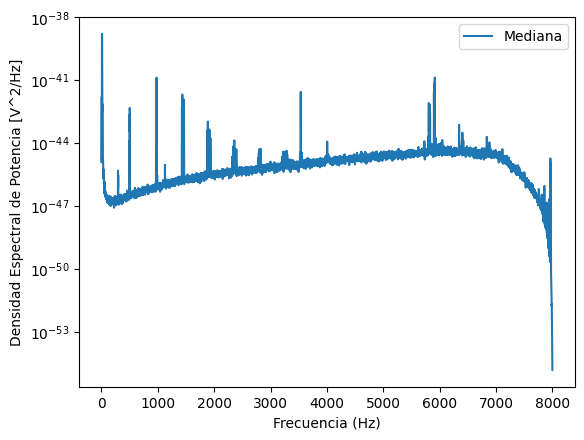

In [98]:
from scipy import signal  # Importa la función welch desde la biblioteca scipy.signal

#Definir la ventana de Tukey
# average="median" calcula la mediana de los espectros de potencia
f_med, pxx_den_med = signal.welch(muestra * ventana, fs, nperseg=fs, average="median")

# Grafica en escala logarítmica la densidad espectral de potencia mediana
plt.semilogy(f_med, pxx_den_med, label="Mediana")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad Espectral de Potencia [V^2/Hz]")
plt.legend()
plt.show()  # Muestra el gráfico





## 4. Procesamiento
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


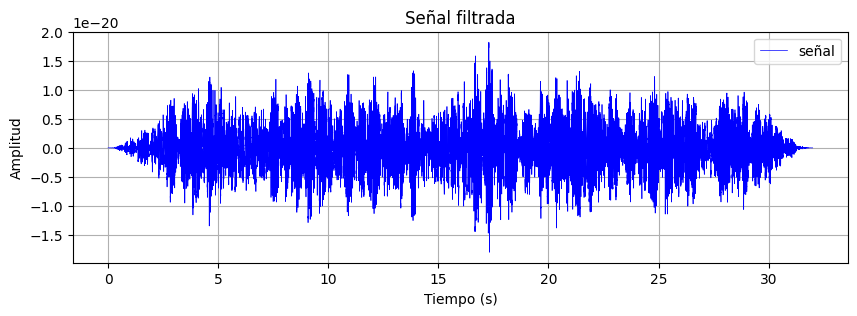

In [100]:
from scipy.signal import butter, filtfilt, tukey
import numpy as np
import matplotlib.pyplot as plt

def pasa_banda(senal, banda_frecuencia, fs):
    # Calcula los coeficientes del filtro
    b, a = butter(4, [banda_frecuencia[0]*2/fs, banda_frecuencia[1]*2/fs], btype="band", output="ba")

    # Normaliza la señal filtrada
    normalizacion = np.sqrt((banda_frecuencia[1] - banda_frecuencia[0]) / (fs/2))

    # Aplica el filtro y normaliza la señal
    senal_bp = filtfilt(b, a, senal) / normalizacion
    return senal_bp

# banda de paso para el filtro
banda_frecuencia = [20, 350]

# Aplica la transformada inversa de Fourier
blanca_inversa = np.fft.irfft(ft_con_ventana, n=N)

# Filtra la señal blanca
senal_filtrada = pasa_banda(blanca_inversa, banda_frecuencia, fs)

# Normaliza la señal filtrada
maximo_absoluto = np.max(np.abs(senal_filtrada))
senal_filtrada_normalizada = (senal_filtrada / maximo_absoluto).astype(np.float32)

# Escribir la señal filtrada en un archivo WAV
write("blanca_filtrada.wav", fs, senal_filtrada_normalizada)

#  archivo WAV
ipd.Audio("blanca_filtrada.wav")

# Grafica la señal filtrada
plt.figure(figsize=(10, 3))
plt.plot(tiempo, senal_filtrada, "b", linewidth=0.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
plt.legend(["señal"])
plt.grid(True)
plt.show()


In [103]:
from scipy.io.wavfile import write
import IPython.display as ipd

datos_muestra_completa = senal_filtrada

# Normaliza la señal al rango [-1, 1]
datos_normalizados = datos_muestra_completa / np.max(np.abs(datos_muestra_completa))

# Convierte la señal a tipo de datos float32
datos_float32 = datos_normalizados.astype(np.float32)

# Escribir los datos de la muestra en un archivo WAV
write("senal_filtrada.wav", fs, datos_float32)

# archivo WAV de la señal filtrada
ipd.Audio("senal_filtrada.wav")


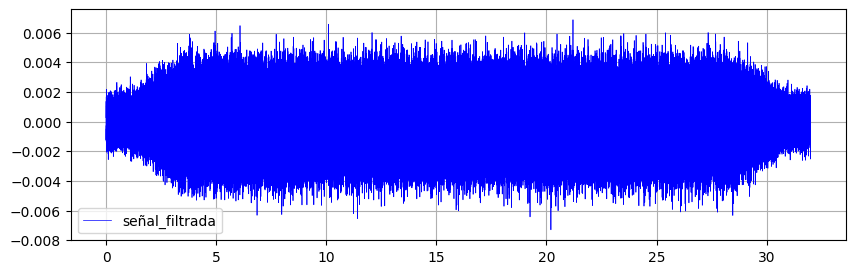

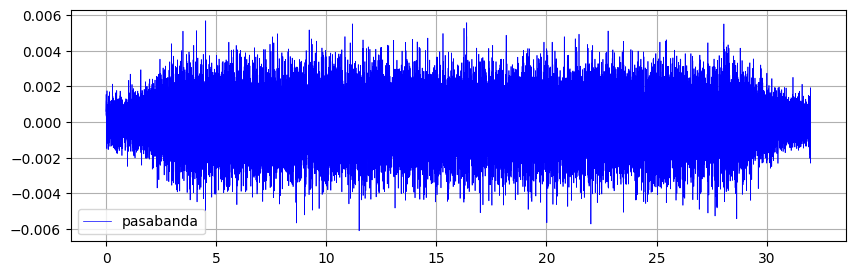

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import math  # Importa el módulo math

def siguiente_potencia_de_2(x):
    return 1 if x == 0 else 2**math.ceil(math.log2(x))

# Calcula el siguiente tamaño de potencia de 2 para la transformada de Fourier
nfft = siguiente_potencia_de_2(N)

# Calcula la transformada de Fourier con la longitud adecuada de nfft
espectro = fft(muestra * ventana, nfft)

# Calcula el espectro de amplitud
espectro_amplitud = np.sqrt(abs(np.multiply(espectro, np.conjugate(espectro))))

# Normaliza el espectro
espectro /= espectro_amplitud

# Calcula la inversa de la transformada de Fourier
ret_blancos = np.real(ifft(espectro, nfft)[:N])

# Filtra la señal blanqueada
senal_filtrada2 = pasa_banda(ret_blancos, banda_frecuencia, fs)

# Gráfico de la señal filtrada
plt.figure(figsize=(10, 3))
plt.plot(pasos_tiempo[:N], ret_blancos, "b", linewidth=.5)
plt.legend(["señal_filtrada"])
plt.grid()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(tiempo, senal_filtrada2, "b", linewidth=.5)
plt.legend(["pasabanda"])
plt.grid()
plt.show()

# Normaliza y guarda la señal filtrada
maximo_absoluto = np.max(np.abs(senal_filtrada2))
senal_filtrada_normalizada = (senal_filtrada2 / maximo_absoluto).astype(np.float32)
write("señal_filtrada.wav", fs, senal_filtrada_normalizada)

# Reproduce el archivo de audio
ipd.Audio("señal_filtrada.wav")


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

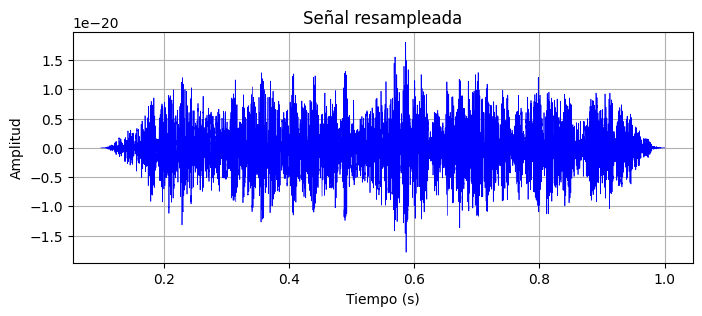

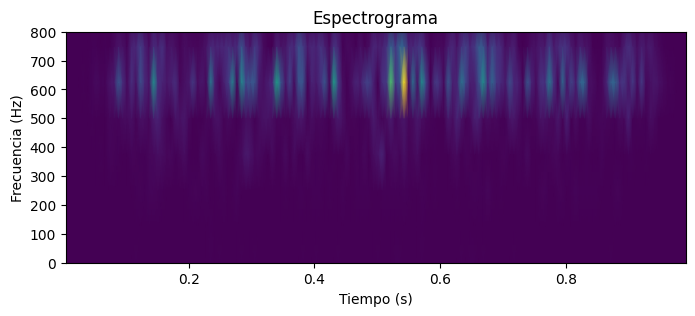

In [125]:
from scipy.signal import butter, filtfilt, resample, spectrogram
from scipy.io.wavfile import write as write_wav
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Frecuencia de muestreo deseada
Fs = 32000

# Resamplea la señal filtrada
muestra_alta = int(Fs / 1)
muestra_baja = int(Fs / 10)
resample_señal = signal.resample(senal_filtrada, Fs)
seccion = resample_señal[muestra_inicial:muestra_final]

# vector de tiempo correspondiente a la sección
pasos_tiempo = np.linspace(muestra_baja / Fs, muestra_alta / Fs, seccion.size)

# Visualiza la sección de la señal resampleada
plt.figure(figsize=(8, 3))
plt.plot(pasos_tiempo, seccion, "b", linewidth=0.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal resampleada")
plt.grid(True)
plt.show()

# Calcula y visualiza el espectrograma
frecuencias, tiempos, Sxx = signal.spectrogram(seccion, Fs)
plt.figure(figsize=(8, 3))
plt.pcolormesh(tiempos, frecuencias, Sxx, shading="gouraud")
plt.ylabel("Frecuencia (Hz)")
plt.xlabel("Tiempo (s)")
plt.title("Espectrograma")
plt.ylim([0, 800])
plt.show()

# Normaliza y guarda la sección resampleada
maximo_absoluto = np.max(np.abs(resample_señal))
seccion_normalizada = (seccion / maximo_absoluto).astype(np.float32)
write_wav("resampleada.wav", Fs, seccion_normalizada)

#  archivo de audio
ipd.Audio("resampleada.wav")
